In [1]:
import cv2
import numpy as np
import struct
import time
import matplotlib.pyplot as plt
import os
import re
import sys
from pathlib import Path

from read_cine import read_cine, convert_cine_to_avi
from track_object import track_object
from main import extract_calibration, detect_chamber

In [2]:
cine_path = r"E:\good_data\He3kA_B250G500G_pl0t20_uw15t35_P30\Y20241102_P30_z13_x200_y0@-0_016.cine"
avi_path = os.path.join(os.getcwd(), "temp_video.avi")

tarr, frarr, dt = read_cine(cine_path)

# convert_cine_to_avi(frarr, avi_path)

# Extract calibration from filename
calibration = extract_calibration(cine_path)

Reading .cine file...
starting frame number: -500
total frames: 1001
frame rate: 20000
Done reading .cine file (4.2 s)


Hough failed, using contour fallback
Chamber detected at (1121, 1110) with radius 609px


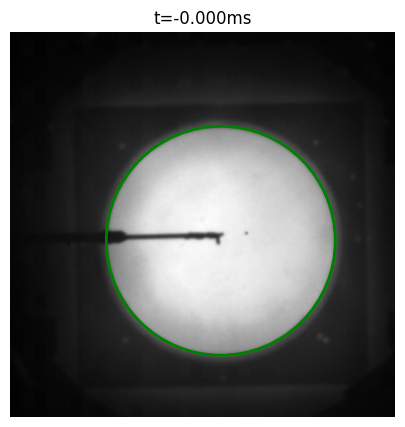

In [6]:
frame_num = 500

cap = cv2.VideoCapture(avi_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
ret, frame = cap.read()
if not ret:
    raise ValueError(f"Could not read frame")

# Detect chamber
(cx, cy), chamber_radius = detect_chamber(frame, calibration)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Draw chamber
drawing = frame.copy()
cv2.circle(drawing, (cx, cy), chamber_radius, (0, 255, 0), 2)

# Display the original frame
plt.figure(figsize=(15, 5))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Draw the chamber as a circle
chamber_circle = plt.Circle((cx, cy), chamber_radius, fill=False, color='green', linewidth=2)
plt.gca().add_patch(chamber_circle)

plt.title(f"t={tarr[frame_num] * 1e3:.3f}ms")
plt.axis('off')

cap.release()

In [4]:
parr, timestamps, frarr, cf = track_object(avi_path, tarr, cx, cy, chamber_radius)

Processing 1001 frames
Frame closest to chamber center: 525


In [7]:
v = 9.8*np.sqrt(2*1/9.8) # velocity at center of chamber in m/s

t1 = tarr[frame_num] - tarr[cf]
t2 = 0.037 - tarr[cf]
print(t1)
print(t2)

x1 = v*t1 + 0.5*9.8*t1**2
x2 = v*t2 + 0.5*9.8*t2**2

print(x1)
print(x2)

-0.0012500000000000011
0.035750000000000004
-0.005526329655294669
0.1645345031414274
